# Reading groundwater observations

This notebook introduces how to use the `hydropandas` package to read, process and visualise groundwater data from Dino and Bro databases.

## <a id=top></a>Notebook contents

1. [GroundwaterObs](#GroundwaterObs)
2. [ObsCollection](#ObsCollection)
3. [Reading ObsCollections](#readingOC)

In [1]:
import hydropandas as hpd

import logging
from IPython.display import HTML

import logging

In [2]:
hpd.util.get_color_logger('INFO');

## GroundwaterObs<a id=GroundwaterObs></a>

The hydropandas package has several functions to read groundwater observations at a measurement well. These include reading data from:
- dino (from csv-files).
- bro (using the bro-api)
- wiski (dumps from the wiski database)

In [3]:
# reading a dino csv file
fname = 'data/Grondwaterstanden_Put/B33F0080001_1.csv'
gw_dino = hpd.GroundwaterObs.from_dino(fname=fname)

INFO:hydropandas.io.io_dino:reading -> B33F0080001_1.csv


In [4]:
# reading the same filter from using the bro api. Specify a groundwater monitoring id (GMW00...) and a filter number (1)
gw_bro = hpd.GroundwaterObs.from_bro("GMW000000041261", 1) 

INFO:hydropandas.io.io_bro:reading bro_id GMW000000041261


Now we have an `GroundwaterObs` object named `gw`. This object contains all the available information of measurement well 'B33F0080' and tube number 1. A `GroundwaterObs` object inherits from a pandas `DataFrame` and has the same attributes and methods.

In [5]:
gw_bro.describe()

,values
count,66411.000000
mean,5.562630
std,0.222262
min,4.913000
25%,5.380000
50%,5.569000
75%,5.721000
max,6.397000


In [6]:
gw_bro

,values,qualifier
1972-11-28 00:00:00,5.763,goedgekeurd
1972-12-07 00:00:00,5.773,goedgekeurd
1972-12-14 00:00:00,5.703,goedgekeurd
1972-12-21 00:00:00,5.643,goedgekeurd
1972-12-28 00:00:00,5.573,goedgekeurd
...,...,...
2021-10-08 07:00:00,5.486,goedgekeurd
2021-10-08 08:00:00,5.485,goedgekeurd
2021-10-08 09:00:00,5.486,goedgekeurd
2021-10-08 09:47:00,5.491,goedgekeurd


Text(0.5, 1.0, 'same tube from Dinoloket B33F0080-001 and BRO id GLD000000009378')

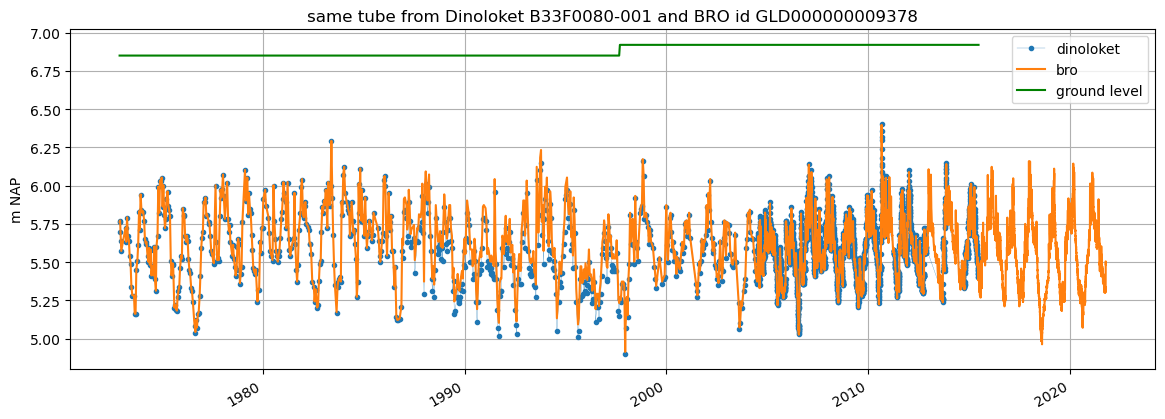

In [7]:
ax = gw_dino['stand_m_tov_nap'].plot(label='dinoloket', figsize=(14,5), legend=True,
                                     marker='.', lw=0.2)
gw_bro['values'].plot(ax=ax, label='bro', legend=True, ylabel=gw_bro.unit)
gw_dino['ground_level'].plot(ax=ax, label='ground level', legend=True, grid=True, color='green',
                             ylabel=gw_dino.unit)

ax.set_title(f'same tube from Dinoloket {gw_dino.name} and BRO id {gw_bro.name}')

#### GroundwaterObs Attributes

Besides the standard `DataFrame` attributes a `GroundwaterObs` has the following additional attributes:
- x, y: x- and y-coordinates of the observation point
- name: str with the name
- filename: str with the filename (only available when the data was loaded from a file)
- monitoring_well: the name of the monitoring_well. One monitoring well can have multiple tubes.
- tube_nr: the number of the tube. The combination of monitoring_well and tube_nr should be unique
- screen_top: the top of the tube screen (bovenkant filter in Dutch)
- screen_bottom: the bottom of the tube screen (onderkant filter in Dutch)
- ground_level: surface level (maaiveld in Dutch)
- tube_top: the top of the tube
- metadata_available: boolean indicating whether metadata is available for this observation point
- meta: dictionary with additional metadata

When dowloading from Dinoloket all levels are in meters NAP.

In [8]:
print(gw_bro)

GroundwaterObs GLD000000009378
-----metadata------
name : GLD000000009378 
x : 213268.0 
y : 473910.0 
filename :  
source : BRO 
unit : m NAP 
monitoring_well : GMW000000041261 
tube_nr : 1 
screen_top : 4.05 
screen_bottom : 3.05 
ground_level : 6.9 
tube_top : 7.173 
metadata_available : True 

-----time series------
                     values    qualifier
1972-11-28 00:00:00   5.763  goedgekeurd
1972-12-07 00:00:00   5.773  goedgekeurd
1972-12-14 00:00:00   5.703  goedgekeurd
1972-12-21 00:00:00   5.643  goedgekeurd
1972-12-28 00:00:00   5.573  goedgekeurd
...                     ...          ...
2021-10-08 07:00:00   5.486  goedgekeurd
2021-10-08 08:00:00   5.485  goedgekeurd
2021-10-08 09:00:00   5.486  goedgekeurd
2021-10-08 09:47:00   5.491  goedgekeurd
2021-10-08 10:00:00   5.485  goedgekeurd

[66411 rows x 2 columns]


#### GroundwaterObs methods

Besides the standard `DataFrame` methods a `GroundwaterObs` has additional methods. This methods are accessible through submodules:
- `geo.get_lat_lon()`, to obtain latitude and longitude
- `gwobs.get_modellayer()`, to obtain the modellayer of a modflow model using the filter depth
- `stats.get_seasonal_stat()`, to obtain seasonal statistics
- `stats.obs_per_year()`, to obtain the number of observations per year
- `stats.consecutive_obs_years()`, to obtain the number of consecutive years with more than a minimum number of observations
- `plots.interactie_plot()`, to obtain a bokeh plot





Get latitude and longitude with `gw.geo.get_lat_lon()`:

In [9]:
print(f'latitude and longitude -> {gw_bro.geo.get_lat_lon()}')

  lat, lon = transform(inProj, outProj, self._obj.x, self._obj.y)

latitude and longitude -> (52.25014706738195, 6.24047994529121)


In [10]:
gw_bro.stats.get_seasonal_stat(stat="mean")

,winter_mean,summer_mean
GLD000000009378,5.723791,5.40682


In [11]:
p= gw_bro.plots.interactive_plot('figure')
HTML(filename="figure/{}.html".format(gw_bro.name))

## ObsCollections<a id=ObsCollections></a>

`ObsCollections` are a combination of multiple observation objects such as `GroundwaterObs` objects. The easiest way to construct an `ObsCollections` is from a list of observation objects.

In [12]:
fname1 = 'data/Grondwaterstanden_Put/B33F0080001_1.csv'
fname2 = 'data/Grondwaterstanden_Put/B33F0133001_1.csv'
gw1 = hpd.GroundwaterObs.from_dino(fname=fname1)
gw2 = hpd.GroundwaterObs.from_dino(fname=fname2)

# create ObsCollection
oc = hpd.ObsCollection.from_list([gw1, gw2], name='Dino groundwater')
oc

INFO:hydropandas.io.io_dino:reading -> B33F0080001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0133001_1.csv


,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
B33F0080-001,213260.0,473900.0,data/Grondwaterstanden_Put/B33F0080001_1.csv,dino,m NAP,B33F0080,1.0,3.85,2.85,6.92,7.18,True,GroundwaterObs B33F0080-001 -----metadata-----...
B33F0133-001,210400.0,473366.0,data/Grondwaterstanden_Put/B33F0133001_1.csv,dino,m NAP,B33F0133,1.0,-67.50,-70.00,6.50,7.14,True,GroundwaterObs B33F0133-001 -----metadata-----...


Now we have an `ObsCollection` object named `oc`. The `ObsCollection` contains all the data from the two `GroundwaterObs` objects. It also stores a reference to the `GroundwaterObs` objects in the 'obs' column. Just like a `GroundwaterObs` object and `ObsCollection` object inherits from a pandas `DataFrame` and has the same attributes and methods.

In [13]:
# get columns
oc.columns

Index(['x', 'y', 'filename', 'source', 'unit', 'monitoring_well', 'tube_nr',
       'screen_top', 'screen_bottom', 'ground_level', 'tube_top',
       'metadata_available', 'obs'],
      dtype='object')

In [14]:
# get statistics
oc.describe()

,x,y,tube_nr,screen_top,screen_bottom,ground_level,tube_top
count,2.000000,2.000000,2.0,2.000000,2.000000,2.000000,2.000000
mean,211830.000000,473633.000000,1.0,-31.825000,-33.575000,6.710000,7.160000
std,2022.325394,377.595021,0.0,50.452069,51.512729,0.296985,0.028284
min,210400.000000,473366.000000,1.0,-67.500000,-70.000000,6.500000,7.140000
25%,211115.000000,473499.500000,1.0,-49.662500,-51.787500,6.605000,7.150000
50%,211830.000000,473633.000000,1.0,-31.825000,-33.575000,6.710000,7.160000
75%,212545.000000,473766.500000,1.0,-13.987500,-15.362500,6.815000,7.170000
max,213260.000000,473900.000000,1.0,3.850000,2.850000,6.920000,7.180000


We can get an overview of the well layout and observations via `plots.section_plot`:

INFO:hydropandas.extensions.plots:created sectionplot -> B33F0133-001


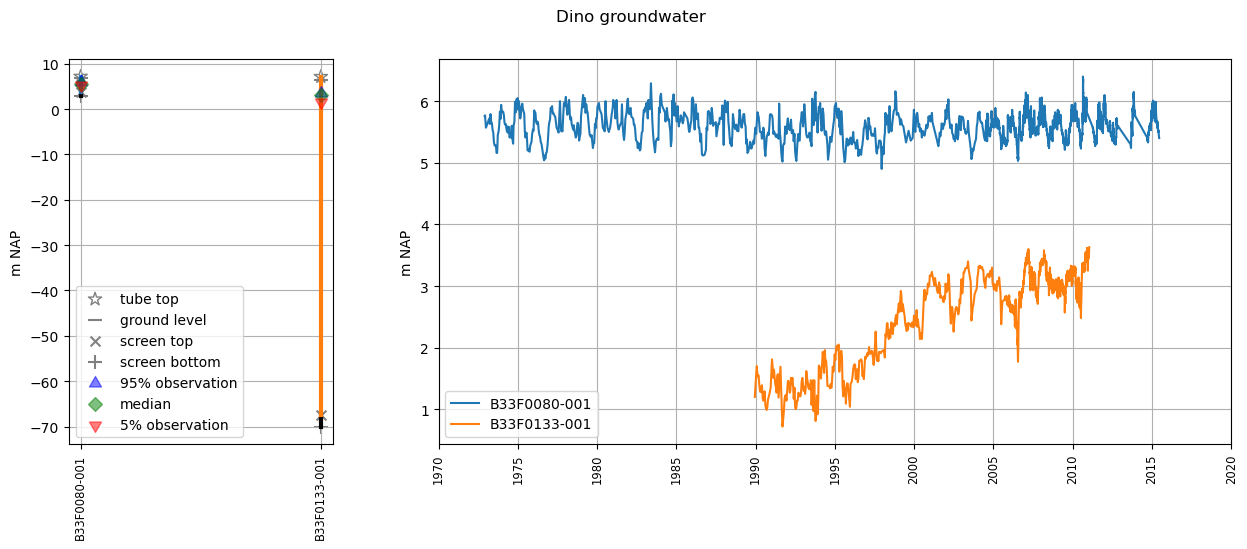

In [15]:
oc.plots.section_plot();

In [16]:
# get individual GroundwaterObs object from an ObsCollection
o = oc.loc['B33F0133-001', 'obs']
o

,stand_m_tov_nap,locatie,filternummer,stand_cm_tov_mp,stand_cm_tov_mv,stand_cm_tov_nap,bijzonderheid,opmerking,tube_top
1989-12-14,1.20,B33F0133,1,582.0,530.0,120.0,NaN,NaN,7.02
1990-01-15,1.57,B33F0133,1,545.0,493.0,157.0,NaN,NaN,7.02
1990-01-29,1.70,B33F0133,1,532.0,480.0,170.0,NaN,NaN,7.02
1990-02-14,1.53,B33F0133,1,549.0,497.0,153.0,NaN,NaN,7.02
1990-03-01,1.56,B33F0133,1,546.0,494.0,156.0,NaN,NaN,7.02
...,...,...,...,...,...,...,...,...,...
2011-01-14,3.57,B33F0133,1,357.0,293.0,357.0,NaN,NaN,7.14
2011-01-15,3.60,B33F0133,1,354.0,290.0,360.0,NaN,NaN,7.14
2011-01-16,3.61,B33F0133,1,353.0,289.0,361.0,NaN,NaN,7.14
2011-01-17,3.61,B33F0133,1,353.0,289.0,361.0,NaN,NaN,7.14


#### ObsCollection Attributes

An `ObsCollection` also has additional attributes:
- name, a str with the name of the collection
- meta, a dictionary with additional metadata

In [17]:
print(f'name is -> {oc.name}')
print(f'meta is -> {oc.meta}')

name is -> Dino groundwater
meta is -> {}


#### ObsCollection methods
Besides the methods of a pandas `DataFrame` an `ObsCollection` has additional methods stored in submodules.

`geo`:
- `get_bounding_box` -> get a tuple with (xmin, ymin, xmax, ymax)
- `get_extent` -> get a tule with (xmin, xmax, ymin, ymax)
- `get_lat_lon` -> to get the lattitudes and longitudes from the x and y coördinates
- `within_polygon` -> to select only the observations that lie within a polygon

`gwobs`:
- `set_tube_nr` -> to set the tube numbers based on the tube screen depth when there are multiple tubes at one monitoring well
- `set_tube_nr_monitoring_well` -> find out which observations are at the same location with a different screen depth. Set monitoring_well and tube_nr attributes accordingly.

`plots`:
- `interactive_figures` -> create bokeh figures for each observation point.
- `interactive_map` -> create a folium map with observation points and bokeh figures for each observation point.

`stats`:
- `get_first_last_obs_date()` -> get the first and the last date of the observations for each observation point
- `get_no_of_observations()` -> get the number of observations
- `get_seasonal_stat()` -> get seasonal stats of the observations

E.g. get the bounding box with `gw.geo.get_lat_lon()`:

In [18]:
print(f'bounding box -> {oc.geo.get_bounding_box()}')

bounding box -> (210400.0, 473366.0, 213260.0, 473900.0)


In [19]:
oc.geo.set_lat_lon()
oc.plots.interactive_map(plot_dir='figure')

  lat, lon = transform(inProj, outProj, self._obj.x, self._obj.y)

  lat, lon = transform(inProj, outProj, self._obj.x, self._obj.y)

INFO:hydropandas.obs_collection:inferred observation type: <class 'hydropandas.observation.GroundwaterObs'>
INFO:hydropandas.extensions.plots:created iplot -> B33F0080-001
INFO:hydropandas.extensions.plots:created iplot -> B33F0133-001
INFO:hydropandas.obs_collection:inferred observation type: <class 'hydropandas.observation.GroundwaterObs'>


## Reading ObsCollections<a id=readingOC></a>

Instead of creating the ObsCollection from a list of observation objects. It is also possible to read the data from a source into an ObsCollection at once. The following sources can be read as an ObsCollection:

- dino (from files)
- bro (using the api)
- fews (dumps from the fews database)
- wiski (dumps from the wiski database)
- arctic (a Mongo database for timeseries)
- menyanthes (a .men file)
- modflow (from the heads of a modflow model)
- imod (from the heads of an imod model)

This notebook won't go into detail on all the sources that can be read. Only the two options for reading data from Dino and BRO are shown below.

In [20]:
# read using a .zip file with data
dinozip = 'data/dino.zip'
dino_gw = hpd.read_dino(dirname=dinozip, keep_all_obs=False)
dino_gw

INFO:hydropandas.io.io_dino:reading -> B02H0092001_1.csv
INFO:hydropandas.io.io_dino:reading -> B02H1007001_1.csv
INFO:hydropandas.io.io_dino:reading -> B04D0032002_1.csv
INFO:root:not added to collection -> C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\Grondwaterstanden_Put\B04D0032002_1.csv
INFO:hydropandas.io.io_dino:reading -> B22D0155001_1.csv
INFO:hydropandas.io.io_dino:reading -> B27D0260001_1.csv
INFO:root:not added to collection -> C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\Grondwaterstanden_Put\B27D0260001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0080001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0080002_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0133001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0133002_1.csv
INFO:hydropandas.io.io_dino:reading -> B37A0112001_1.csv
INFO:root:not added to collection -> C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\Grondwaterstanden_Put\B37A0112001_1.csv
INFO:hydropandas.io.io_dino:reading -> B42B0003001_1.csv
INFO

,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
B02H0092-001,219890.0,600030.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B02H0092,1.0,NaN,NaN,NaN,NaN,True,GroundwaterObs B02H0092-001 -----metadata-----...
B02H1007-001,219661.0,600632.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B02H1007,1.0,NaN,NaN,1.92,NaN,True,GroundwaterObs B02H1007-001 -----metadata-----...
B22D0155-001,233830.0,502530.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B22D0155,1.0,7.80,6.80,8.91,9.94,True,GroundwaterObs B22D0155-001 -----metadata-----...
B33F0080-001,213260.0,473900.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B33F0080,1.0,3.85,2.85,6.92,7.18,True,GroundwaterObs B33F0080-001 -----metadata-----...
B33F0080-002,213260.0,473900.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B33F0080,2.0,-10.15,-12.15,6.92,7.17,True,GroundwaterObs B33F0080-002 -----metadata-----...
B33F0133-001,210400.0,473366.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B33F0133,1.0,-67.50,-70.00,6.50,7.14,True,GroundwaterObs B33F0133-001 -----metadata-----...
B33F0133-002,210400.0,473366.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B33F0133,2.0,-104.20,-106.20,6.50,7.12,True,GroundwaterObs B33F0133-002 -----metadata-----...
B42B0003-001,38165.0,413785.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B42B0003,1.0,-2.00,-3.00,6.50,6.99,True,GroundwaterObs B42B0003-001 -----metadata-----...
B42B0003-002,38165.0,413785.0,C:\Users\HMEUW\AppData\Local\Temp\tmpnuqmqcsy\...,dino,m NAP,B42B0003,2.0,-34.00,-35.00,6.50,6.99,True,GroundwaterObs B42B0003-002 -----metadata-----...


In [21]:
# read from bro using an extent (Schoonhoven zuid-west)
oc = hpd.read_bro(extent=(117850, 118180, 439550, 439900), keep_all_obs=False)
oc

  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

INFO:hydropandas.io.io_bro:reading bro_id GMW000000036327


  3%|██▎                                                                                | 1/35 [00:09<05:24,  9.56s/it]

INFO:hydropandas.io.io_bro:reading bro_id GMW000000049567
INFO:hydropandas.io.io_bro:no groundwater level dossier for GMW000000049567 and tube number 1
INFO:hydropandas.io.io_bro:reading bro_id GMW000000049567
INFO:hydropandas.io.io_bro:no groundwater level dossier for GMW000000049567 and tube number 2


  6%|████▋                                                                              | 2/35 [00:12<03:15,  5.91s/it]

INFO:hydropandas.io.io_bro:reading bro_id GMW000000036365


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [00:21<00:00,  2.11it/s]

INFO:hydropandas.io.io_bro:reading bro_id GMW000000036319


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:32<00:00,  1.08it/s]


,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
GLD000000012821,118064.196,439799.968,,BRO,m NAP,GMW000000036327,1,-0.833,-1.833,0.856,0.716,True,GroundwaterObs GLD000000012821 -----metadata--...
GLD000000012908,118127.470,439683.136,,BRO,m NAP,GMW000000036365,1,-0.429,-1.428,1.371,1.221,True,GroundwaterObs GLD000000012908 -----metadata--...
GLD000000012818,117957.010,439698.236,,BRO,m NAP,GMW000000036319,1,-1.721,-2.721,-0.501,-0.621,True,GroundwaterObs GLD000000012818 -----metadata--...


INFO:hydropandas.extensions.plots:created sectionplot -> GLD000000012818


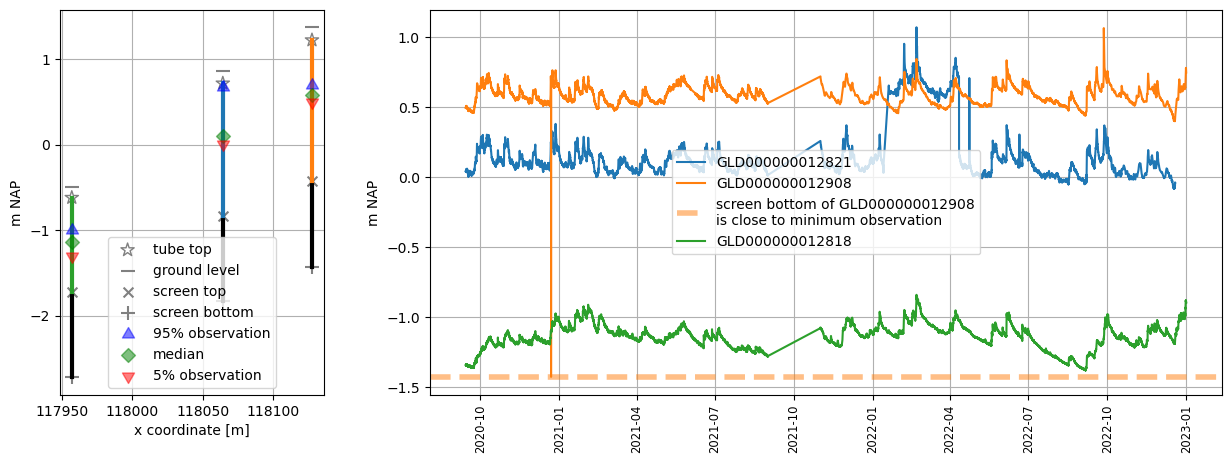

In [22]:
# plot wells, use x-coordinate in section plot
oc.plots.section_plot(section_colname_x='x',section_label_x='x coordinate [m]');